In [1]:
import os
import errno
import pandas as pd
import numpy as np
import deepcell
import math


from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from deepcell.utils.io_utils import *
from deepcell.utils.plot_utils import get_js_video
from IPython.display import HTML
from tensorflow.python.keras import backend as K

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


/usr/local/lib/python3.6/dist-packages/deepcell/utils/__init__.py:49: UserWarning: To use `compute_overlap`, the C extensions must be built using `python setup.py build_ext --inplace`
  warnings.warn('To use `compute_overlap`, the C extensions must be built '


In [2]:
def _get_3D_images_from_directory(data_location, channel_names, image_size=(50,512,512), dtype='float32'):
    """Read all images from directory with channel_name in the filename

    Args:
        data_location (str): folder containing image files
        channel_names (str[]): list of wildcards to select filenames

    Returns:
        numpy.array: numpy array of each image in the directory
    """
    data_format = K.image_data_format()
    img_list_channels = []
    for channel in channel_names:
        img_list_channels.append(nikon_getfiles(data_location, channel))

    #img_temp = np.asarray(get_image(os.path.join(data_location, img_list_channels[0][0])))
    img_temp = np.zeros(image_size, dtype)

    n_channels = len(channel_names)
    all_images = []

    for stack_iteration in range(len(img_list_channels[0])):

        if data_format == 'channels_first':
            shape = (1, n_channels, img_temp.shape[0], img_temp.shape[1], img_temp.shape[2])
        else:
            shape = (1, img_temp.shape[0], img_temp.shape[1], img_temp.shape[2], n_channels)

        all_channels = np.zeros(shape, dtype=K.floatx())

        for j in range(n_channels):
            img_path = os.path.join(data_location, img_list_channels[j][stack_iteration])
            channel_img = get_image(img_path)

            # Images in this dataset have different dimensions along all 3 axes
            # 
            f_dim = channel_img.shape[0] ##
            x_dim = channel_img.shape[1] ##
            y_dim = channel_img.shape[2] ##
            
            if data_format == 'channels_first':
                all_channels[0, j, :f_dim, :x_dim, :y_dim] = channel_img
            else:
                all_channels[0, :f_dim, :x_dim, :y_dim, j] = channel_img

        all_images.append(all_channels)

    return all_images

In [3]:
# Retrieve data and format into a numpy array of dims (batch, z, x, y, channels)
# Note: channels 1 and 2 are input channels, channel 3 is nuclear annotations

path_to_data = '/deepcell_data/users/collaborations/raj_lab/RajLab_3D_Organoid_19_07_17'
channel_names = ['dapi', 'gfp', 'nuclei']

raw_img_list = _get_3D_images_from_directory(path_to_data, channel_names)
print('number of z_stacks in data is: ', len(raw_img_list))
print('shape of each z_stack is: ', raw_img_list[0].shape)

raw_img_array = np.squeeze(np.asarray(raw_img_list, dtype='float32'))
print('final data shape is: ', raw_img_array.shape)

number of z_stacks in data is:  18
shape of each z_stack is:  (1, 50, 512, 512, 3)
final data shape is:  (18, 50, 512, 512, 3)


In [15]:
a = [[1,1],[1,1]]
a = np.pad(a, b, 'constant')

In [14]:
b = ((1,2), (3,2))

In [16]:
a

array([[0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 0, 0],
       [0, 0, 0, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0]])

In [6]:
X_slice = np.expand_dims(raw_img_array, axis=1)

HTML(get_js_video(X_slice[2], batch=0, channel=2, interval=300))

In [5]:
X_slice = np.expand_dims(raw_img_array, axis=1)

HTML(get_js_video(X_slice[2], batch=0, channel=0, interval=300))

In [29]:
# TODO - make this work with overlaps aside from slices-1
# actually jk dont think we need this at all.
# might want it to cut z stacks in half to increase # batches though

def _overlapping_slices_3D(input_array, output_slices=5, overlap=4):
    
    input_num_stacks = input_array.shape[0]
    input_frames = input_array.shape[1]    # should be 50
    input_x = input_array.shape[2]
    input_y = input_array.shape[3]
    input_chan = input_array.shape[4]
    
    increment = output_slices - overlap
    final_z_start = input_frames + 1 - output_slices
    
    num_per_stack = math.trunc(final_z_start / increment)    # number of stacks obtained from one input z_stack
    output_height = num_per_stack * input_num_stacks
    print('output height = ', output_height)
    
    
    stack_height = 0   
    
    sliced = np.zeros((output_height, output_slices, input_x, input_y, input_chan), dtype='float32')

    print('shape of sliced = ', sliced.shape)
    
    for z_start in range(0, final_z_start, increment):
        
        z_end = z_start + output_slices
        z_stack = input_array[:, z_start:z_end, ...]
        
        # print('z_stack shape = ', z_stack.shape)
        
        sliced[stack_height:stack_height+input_num_stacks, ...] = z_stack
        
        #sliced = np.concatenate((sliced, z_stack), axis=0)
        
        stack_height += input_num_stacks   # increment by num_stacks (e.g. 18)
    
    
    return sliced


In [30]:
#Slice data into overlapping stacks 5 frames high
sliced_data = _overlapping_slices_3D(raw_img_array, overlap=4)#
X = sliced_data[..., 0:2]
y = sliced_data[..., 2:3]

# No need to slice data
#X = raw_img_array[..., 0:2]
#y = raw_img_array[..., 2:3]

print('Shape of raw_img_array is: ', raw_img_array.shape)
print('Shape of X is: ', X.shape)
print('Shape of y is: ', y.shape)



output height =  828
shape of sliced =  (828, 5, 512, 512, 3)
Shape of raw_img_array is:  (18, 50, 512, 512, 3)
Shape of X is:  (828, 5, 512, 512, 2)
Shape of y is:  (828, 5, 512, 512, 1)


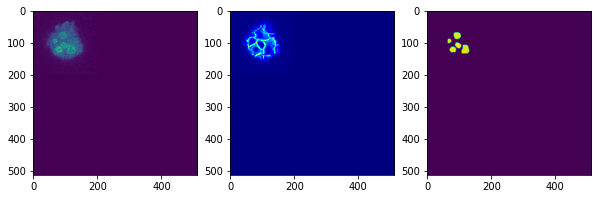

In [31]:
# Visualize annotations
# ** note: the dimensions of each z_stack vary along all 3 dimensions. To account for this, 
# **       _get_3D_images_from_directory pads each image to size 50x512x512. The blank space is
# **       excised by the data_generator, as it has no objects. 

num = 11
slice = 1

fig, ax = plt.subplots(1,3,figsize=(10, 8))
ax[0].imshow(X[num, slice,  ..., 0])
ax[1].imshow(X[num, slice, ..., 1], cmap='jet')
ax[2].imshow(y[num, slice, ..., 0])
plt.show()

In [60]:
# Visualize movie data 

y_slice = np.expand_dims(y, axis=1)
X_slice = np.expand_dims(X, axis=1)

print(X_slice.shape)

HTML(get_js_video(X_slice[num], batch=0, channel=0, interval=300)) # change X_slice to y_slice to view annotations

(828, 1, 5, 512, 512, 2)


In [33]:
print(X_slice.shape)

(828, 1, 5, 512, 512, 2)


In [34]:
# Split data into train and test

seed=7
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)


In [35]:
# Reshape input to square input of a given size
from deepcell.utils.data_utils import reshape_movie

size = 256

X_train, y_train = reshape_movie(X_train, y_train, reshape_size=size)
X_test, y_test = reshape_movie(X_test, y_test, reshape_size=size)
print('X.shape: {}\ny.shape: {}'.format(X_train.shape, y_train.shape))

Reshaped feature data from (662, 5, 512, 512, 1) to (2648, 5, 256, 256, 1)
Reshaped training data from (662, 5, 512, 512, 2) to (2648, 5, 256, 256, 2)
Reshaped feature data from (166, 5, 512, 512, 1) to (664, 5, 256, 256, 1)
Reshaped training data from (166, 5, 512, 512, 2) to (664, 5, 256, 256, 2)
X.shape: (2648, 5, 256, 256, 2)
y.shape: (2648, 5, 256, 256, 1)


## Set up filepath constants


In [36]:
# change DATA_DIR if you are not using `deepcell.datasets`
DATA_DIR = path_to_data

# DATA_FILE should be an npz file, preferably from `make_training_data`
filename = 'Raj_3D_sliced.npz'
DATA_FILE = os.path.join(DATA_DIR, filename)

# Save as .npz
#np.savez_compressed(DATA_FILE, X=X, y=y)

# confirm the data file is available
#assert os.path.isfile(DATA_FILE)

In [37]:
# Set up other required filepaths

# If the data file is in a subdirectory, mirror it in MODEL_DIR and LOG_DIR
PREFIX = os.path.relpath(os.path.dirname(DATA_FILE), DATA_DIR)

ROOT_DIR = '/deepcell_data'  # TODO: Change this! Usually a mounted volume
MODEL_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'models', PREFIX))
LOG_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'logs', PREFIX))

print(MODEL_DIR)

# create directories if they do not exist
for d in (MODEL_DIR, LOG_DIR):
    try:
        os.makedirs(d)
    except OSError as exc:  # Guard against race condition
        if exc.errno != errno.EEXIST:
            raise

/deepcell_data/models


## Create the PanopticNet Model

Here we instantiate a `PanopticNet` model from `deepcell.model_zoo` using 3 semantic heads:
inner distance (1 class),
outer distance (1 class),
foreground/background distance (2 classes)

In [38]:
frames_per_batch = 5

In [39]:
frames_per_batch = 4

In [40]:
from deepcell.model_zoo.panopticnet import PanopticNet


model = PanopticNet(
    backbone='resnet50',
    input_shape=X_train.shape[2:],
    frames_per_batch=frames_per_batch, 
    norm_method='std',
    num_semantic_heads=3,
    num_semantic_classes=[1, 1, 2], # inner distance, outer distance, fgbg
    location=True,  # should always be true
    include_top=True)

## Prepare for training

### Set up training parameters.

There are a number of tunable hyper parameters necessary for training deep learning models:

**model_name**: Incorporated into any files generated during the training process.

**backbone**: The majority of DeepCell models support a variety backbone choices specified in the "backbone" parameter. Backbones are provided through [keras_applications](https://github.com/keras-team/keras-applications) and can be instantiated with weights that are pretrained on ImageNet.

**n_epoch**: The number of complete passes through the training dataset.

**lr**: The learning rate determines the speed at which the model learns. Specifically it controls the relative size of the updates to model values after each batch.

**optimizer**: The TensorFlow module [tf.keras.optimizers](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers) offers optimizers with a variety of algorithm implementations. DeepCell typically uses the Adam or the SGD optimizers.

**lr_sched**: A learning rate scheduler allows the learning rate to adapt over the course of model training. Typically a larger learning rate is preferred during the start of the training process, while a small learning rate allows for fine-tuning during the end of training.

**batch_size**: The batch size determines the number of samples that are processed before the model is updated. The value must be greater than one and less than or equal to the number of samples in the training dataset.


In [41]:
from tensorflow.keras.optimizers import SGD, Adam
from deepcell.utils.train_utils import rate_scheduler

model_name = 'raj_3D_watershed_test'
model_path = os.path.join(MODEL_DIR, '{}.h5'.format(model_name))
loss_path = os.path.join(MODEL_DIR, '{}.npz'.format(model_name))

n_epoch = 5  # Number of training epochs
test_size = .20  # % of data saved as test
norm_method = 'whole_image'  # data normalization

optimizer = Adam(lr=1e-5, clipnorm=0.001)
lr_sched = rate_scheduler(lr=1e-5, decay=0.99)

batch_size = 1

min_objects = 2  # throw out images with fewer than this many objects

### Create the DataGenerators

The `SemanticDataGenerator` can output any number of transformations for each image. These transformations are passed to `generator.flow()` as a list of transform names.

Here we use `"inner-distance"`, `"outer-distance"` and `"fgbg"` to correspond to the inner distance, outer distance, and foreground background semantic heads, respectively. Keyword arguments may also be passed to each transform as a `dict` of transform names to `kwargs`.

In [42]:
from deepcell import image_generators
from deepcell.utils import train_utils

transforms = ['inner-distance', 'outer-distance', 'fgbg']
transforms_kwargs = {'outer-distance': {'erosion_width': 0}}

# use augmentation for training but not validation
datagen = image_generators.SemanticMovieGenerator(
    rotation_range=180,
    shear_range=0,
    zoom_range=(0.75, 1.25),
    fill_mode='reflect',
    cval=0,
    horizontal_flip=True,
    vertical_flip=True)

datagen_val = image_generators.SemanticMovieGenerator(
    rotation_range=0,
    shear_range=0,
    zoom_range=0,
    fill_mode='reflect',
    cval=0,
    horizontal_flip=0,
    vertical_flip=0)

In [43]:
train_data = datagen.flow(
    {'X': X_train, 'y': y_train},
    seed=seed,
    transforms=transforms,
    frames_per_batch=frames_per_batch,
    transforms_kwargs=transforms_kwargs,
    min_objects=min_objects,
    batch_size=batch_size)

val_data = datagen_val.flow(
    {'X': X_test, 'y': y_test},
    seed=seed,
    frames_per_batch=frames_per_batch,
    transforms=transforms,
    transforms_kwargs=transforms_kwargs,
    min_objects=min_objects,
    batch_size=batch_size)

In [47]:
from matplotlib import pyplot as plt

inputs, outputs = train_data.next()

img = inputs[0]
inner_distance = outputs[0]
outer_distance = outputs[1]
fgbg = outputs[2]

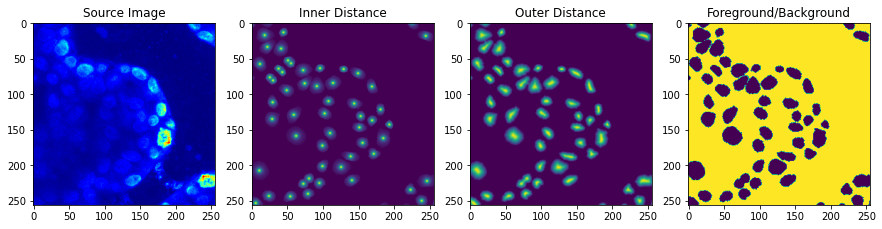

In [50]:
fig, axes = plt.subplots(1, 4, figsize=(15, 15))

slice=3

axes[0].imshow(img[slice, ..., 0], cmap='jet')
axes[0].set_title('Source Image')

axes[1].imshow(inner_distance[0, slice, ..., 0])
axes[1].set_title('Inner Distance')

axes[2].imshow(outer_distance[0, slice, ..., 0])
axes[2].set_title('Outer Distance')

axes[3].imshow(fgbg[0, slice, ..., 0])
axes[3].set_title('Foreground/Background')

plt.show()

### Create a loss function for each semantic head

Each semantic head is trained with it's own loss function. Mean Square Error is used for regression-based heads, whereas `weighted_categorical_crossentropy` is used for classification heads.

The losses are saved as a dictionary and passed to `model.compile`.

In [51]:
# Create a dictionary of losses for each semantic head
from tensorflow.python.keras.losses import MSE
from deepcell import losses


def semantic_loss(n_classes):
    def _semantic_loss(y_pred, y_true):
        if n_classes > 1:
            return 0.01 * losses.weighted_categorical_crossentropy(
                y_pred, y_true, n_classes=n_classes)
        return MSE(y_pred, y_true)
    return _semantic_loss


loss = {}

# Give losses for all of the semantic heads
for layer in model.layers:
    if layer.name.startswith('semantic_'):
        n_classes = layer.output_shape[-1]
        loss[layer.name] = semantic_loss(n_classes)
        
model.compile(loss=loss, optimizer=optimizer)

In [52]:
from deepcell.utils.train_utils import get_callbacks
from deepcell.utils.train_utils import count_gpus




num_gpus = count_gpus()

print('Training on', num_gpus, 'GPUs.')

train_callbacks = get_callbacks(
    model_path,
    lr_sched=lr_sched,
    tensorboard_log_dir=LOG_DIR,
    save_weights_only=num_gpus >= 2,
    monitor='val_loss',
    verbose=1)

loss_history = model.fit_generator(
    train_data,
    steps_per_epoch=train_data.y.shape[0] // batch_size,
    epochs=n_epoch,
    validation_data=val_data,
    validation_steps=val_data.y.shape[0] // batch_size,
    callbacks=train_callbacks)

Training on 1 GPUs.
Epoch 1/5
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
 268/1167 [=====>........................] - ETA: 1:50 - loss: 0.0074 - semantic_0_loss: 0.0019 - semantic_1_loss: 0.0034 - semantic_2_loss: 0.0021
Epoch 00001: val_loss improved from inf to 0.00735, saving model to /deepcell_data/models/raj_3D_watershed_test.h5
1167/1167 [==============================] - 538s 461ms/step - loss: 0.0399 - semantic_0_loss: 0.0276 - semantic_1_loss: 0.0087 - semantic_2_loss: 0.0035 - val_loss: 0.0074 - val_semantic_0_loss: 0.0019 - val_semantic_1_loss: 0.0034 - val_semantic_2_loss: 0.0021
Epoch 2/5
 268/1167 [=====>........................] - ETA: 1:28 - loss: 0.0076 - semantic_0_loss: 0.0021 - semantic_1_loss: 0.0037 - semantic_2_loss: 0.0018
Epoch 00002: val_loss did not improve from 0.00735
1167/1167 [==============================] - 410s 351ms/step - loss: 0.0062 - semantic_0_loss: 0.0018 - semantic_1_loss: 0.0030 - semantic_2_

## Predict on test data

Use the trained model to predict on new data. First, create a new prediction model without the foreground background semantic head. While this head is very useful during training, the output is unused during prediction. By using `model.load_weights(path, by_name=True)`, the semantic head can be removed.

In [53]:
from deepcell.model_zoo.panopticnet import PanopticNet       

pred_frames_per_batch = frames_per_batch

prediction_model = PanopticNet(
    backbone='resnet50',
    input_shape=X_train.shape[2:],
    frames_per_batch=pred_frames_per_batch,
    norm_method='std',
    num_semantic_heads=2,
    num_semantic_classes=[1, 1], # inner distance, outer distance
    location=True,  # should always be true
    include_top=True)

prediction_model.load_weights(model_path, by_name=True)

In [54]:
# make predictions on testing data
from timeit import default_timer

begin_frame = 0
end_frame = 5

start = default_timer()
test_images = prediction_model.predict(X_test[begin_frame:end_frame, 0:frames_per_batch, ...])
watershed_time = default_timer() - start

print('Watershed segmentation of shape', test_images[0].shape, 'in', watershed_time, 'seconds.')

Watershed segmentation of shape (8, 4, 256, 256, 1) in 8.393998298794031 seconds.


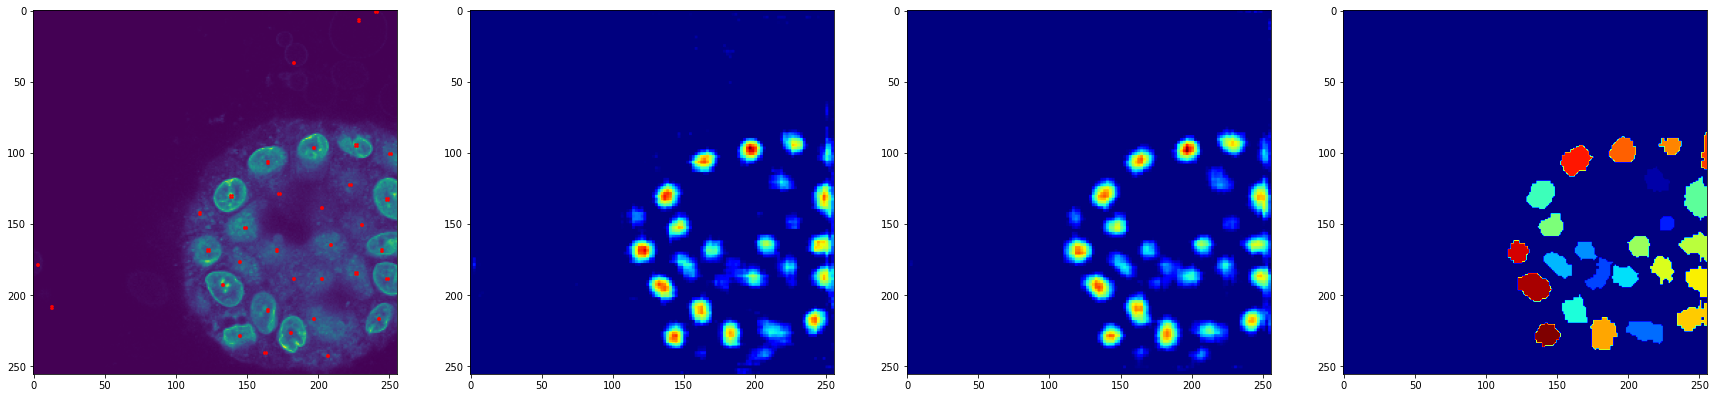

In [56]:
import time

from matplotlib import pyplot as plt
import numpy as np

from skimage.feature import peak_local_max

from deepcell_toolbox.deep_watershed import deep_watershed_3D

masks = deep_watershed_3D(
    test_images,
    min_distance=10,
    detection_threshold=0.1,
    distance_threshold=0.01,
    exclude_border=False,
    small_objects_threshold=50)

# calculated in the postprocessing above, but useful for visualizing
inner_distance = test_images[0]
outer_distance = test_images[1]

fig, axes = plt.subplots(1, 4, figsize=(30, 30))

index = 4
slice = 3

coords = peak_local_max(
    inner_distance[index],
    min_distance=10,
    threshold_abs=0.1,
    exclude_border=False)

# raw image with centroid
axes[0].imshow(X_test[index+begin_frame, slice, ..., 0])
axes[0].scatter(coords[..., 2], coords[..., 1],
                color='r', marker='.', s=10)

axes[1].imshow(inner_distance[index, slice, ..., 0], cmap='jet')
axes[2].imshow(outer_distance[index, slice, ..., 0], cmap='jet')
axes[3].imshow(masks[index, slice, ...], cmap='jet')

plt.show()

In [58]:
# Play movie of the predicted masks
vid_msk = np.expand_dims(masks, axis=1)
vid_msk = np.expand_dims(vid_msk, axis=-1)

HTML(get_js_video(vid_msk[index], batch=0, channel=0, interval=800))

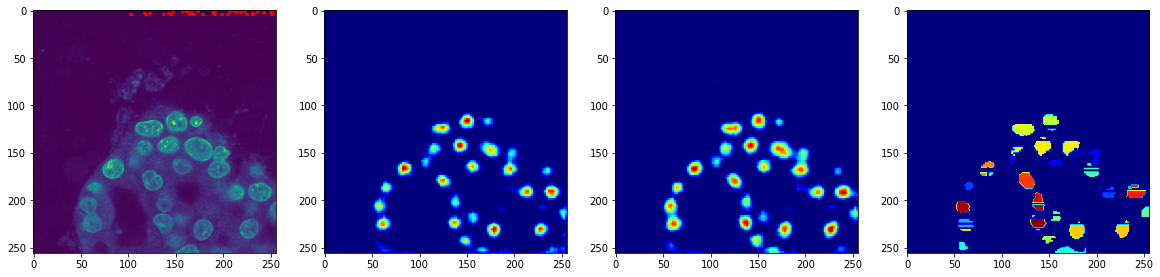

In [34]:
import time

from matplotlib import pyplot as plt
import numpy as np

from skimage.feature import peak_local_max

from deepcell_toolbox.deep_watershed import deep_watershed

masks = deep_watershed(
    test_images,
    min_distance=10,
    detection_threshold=0.1,
    distance_threshold=0.01,
    exclude_border=False,
    small_objects_threshold=0)

# calculated in the postprocessing above, but useful for visualizing
inner_distance = test_images[0]
outer_distance = test_images[1]

fig, axes = plt.subplots(1, 4, figsize=(20, 20))

index = 8
slice = 2

coords = peak_local_max(
    inner_distance[index],
    min_distance=10,
    threshold_abs=0.1,
    exclude_border=False)

# raw image with centroid
axes[0].imshow(X_test[index+begin_frame, slice, ..., 0])
axes[0].scatter(coords[..., 1], coords[..., 0],
                color='r', marker='.', s=10)

axes[1].imshow(inner_distance[index, slice, ..., 0], cmap='jet')
axes[2].imshow(outer_distance[index, slice, ..., 0], cmap='jet')
axes[3].imshow(masks[index, slice, ...], cmap='jet')

plt.show()

In [ ]:
# channels = ['dapi', 'gfp', 'nuclei']
# data = _get_3D_images_from_directory(path_to_data, channels)


# convert data to np.array

# X = data[..., 0:1]
# y = data[..., 2]


# X_train, y_train, X_test, y_test = train_test_split(X, y, test_size = 0.2, random_state=seed)

# reshape_movie to size 256
# HTML(get_js_video(ims[7], batch=0, channel=2))